# COG Functional Category Analysis Across Gene Classes

This notebook analyzes how COG (Clusters of Orthologous Groups) functional categories differ across:
- **Core genes**: Present in most/all genomes within a species
- **Auxiliary genes**: Present in some genomes
- **Singleton/Novel genes**: Present in only one genome

## Hypothesis
Novel genes will have different functional profiles than core genes, potentially enriched in:
- Mobile elements
- Defense mechanisms  
- Poorly characterized functions

Core genes expected to be enriched in:
- Translation machinery
- Essential metabolism
- Cell division processes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
#from get_spark_session import get_spark_session

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Initialize Spark session
spark = get_spark_session()
print(f"Spark version: {spark.version}")
#print(f"Spark app name: {spark.sparkContext.appName}")

Spark version: 4.0.1


## Step 1: Select a well-represented species

We'll start with a species that has many genomes for robust statistics.

In [4]:
# Find species with many genomes
species_query = """
SELECT 
    s.GTDB_species,
    s.gtdb_species_clade_id,
    p.no_genomes,
    p.no_core,
    p.no_aux_genome,
    p.no_singleton_gene_clusters
FROM kbase_ke_pangenome.pangenome p
JOIN kbase_ke_pangenome.gtdb_species_clade s
    ON p.gtdb_species_clade_id = s.gtdb_species_clade_id
WHERE p.no_genomes > 100 AND p.no_genomes < 500
ORDER BY p.no_genomes DESC
LIMIT 20
"""

species_df = spark.sql(species_query).toPandas()
print("Top species by genome count:")
print(species_df)

# Display in a nice format
species_df

Top species by genome count:
                          GTDB_species  \
0                s__Streptococcus_equi   
1              s__Bacillus_A_anthracis   
2              s__Phocaeicola_vulgatus   
3             s__Cronobacter_sakazakii   
4   s__Staphylococcus_pseudintermedius   
5             s__Serratia_marcescens_K   
6          s__Burkholderia_multivorans   
7               s__Sarcina_perfringens   
8             s__Bacteroides_uniformis   
9          s__Klebsiella_michiganensis   
10               s__Xanthomonas_oryzae   
11             s__Klebsiella_aerogenes   
12      s__Corynebacterium_diphtheriae   
13            s__Enterococcus_B_lactis   
14           s__Helicobacter_pylori_BU   
15           s__Leptospira_interrogans   
16              s__Cutibacterium_acnes   
17             s__Acinetobacter_pittii   
18            s__Pasteurella_multocida   
19         s__Burkholderia_cenocepacia   

                                gtdb_species_clade_id no_genomes no_core  \
0           

,GTDB_species,gtdb_species_clade_id,no_genomes,no_core,no_aux_genome,no_singleton_gene_clusters
0,s__Streptococcus_equi,s__Streptococcus_equi--GB_GCA_900637675.1,472,1830,15913,10576
1,s__Bacillus_A_anthracis,s__Bacillus_A_anthracis--RS_GCF_000742895.1,455,4530,45003,24380
2,s__Phocaeicola_vulgatus,s__Phocaeicola_vulgatus--RS_GCF_000012825.1,449,2635,71920,39652
3,s__Cronobacter_sakazakii,s__Cronobacter_sakazakii--RS_GCF_000982825.1,449,3468,38955,22032
4,s__Staphylococcus_pseudintermedius,s__Staphylococcus_pseudintermedius--RS_GCF_001...,426,2040,24203,16256
5,s__Serratia_marcescens_K,s__Serratia_marcescens_K--RS_GCF_002220655.1,425,4110,31431,19987
6,s__Burkholderia_multivorans,s__Burkholderia_multivorans--RS_GCF_000959525.1,404,4609,48640,27101
7,s__Sarcina_perfringens,s__Sarcina_perfringens--RS_GCF_000013285.1,403,2325,31313,15301
8,s__Bacteroides_uniformis,s__Bacteroides_uniformis--GB_GCA_025147485.1,401,2427,74048,41774
9,s__Klebsiella_michiganensis,s__Klebsiella_michiganensis--RS_GCF_002925905.1,399,4597,57138,30368


## Step 2: Select species and verify SQL handling

Let's test whether exact equality works with species IDs containing `--`.

In [5]:
# Select a species with moderate genome count for good statistics
# Using exact species_clade_id from the query above
SPECIES_ID = "s__Neisseria_gonorrhoeae--RS_GCF_003315235.1"

# Test if exact equality works (it should!)
test_query = f"""
SELECT 
    gtdb_species_clade_id,
    COUNT(*) as cluster_count
FROM kbase_ke_pangenome.gene_cluster
WHERE gtdb_species_clade_id = '{SPECIES_ID}'
GROUP BY gtdb_species_clade_id
"""

test_result = spark.sql(test_query).toPandas()
print("Testing exact equality with species ID containing '--':")
print(test_result)

if len(test_result) > 0:
    print("\n✓ Exact equality works fine! The '--' inside quotes is not a problem.")
else:
    print("\n✗ Exact equality failed. Need to investigate.")

Testing exact equality with species ID containing '--':
                          gtdb_species_clade_id  cluster_count
0  s__Neisseria_gonorrhoeae--RS_GCF_003315235.1          19895

✓ Exact equality works fine! The '--' inside quotes is not a problem.


## Step 3: Get gene cluster statistics for selected species

In [6]:
# Count clusters by class using exact equality
cluster_stats_query = f"""
SELECT 
    is_core,
    is_auxiliary,
    is_singleton,
    COUNT(*) as cluster_count
FROM kbase_ke_pangenome.gene_cluster
WHERE gtdb_species_clade_id = '{SPECIES_ID}'
GROUP BY is_core, is_auxiliary, is_singleton
ORDER BY is_core DESC, is_auxiliary DESC, is_singleton DESC
"""

cluster_stats = spark.sql(cluster_stats_query).toPandas()
print("Gene cluster counts by class:")
print(cluster_stats)

# Create readable labels
def get_class_label(row):
    if row['is_core'] == 1:
        return 'Core'
    elif row['is_singleton'] == 1:
        return 'Singleton/Novel'
    else:
        return 'Auxiliary'

cluster_stats['gene_class'] = cluster_stats.apply(get_class_label, axis=1)
print("\nClusters by gene class:")
print(cluster_stats[['gene_class', 'cluster_count']])

Gene cluster counts by class:
  is_core is_auxiliary is_singleton  cluster_count
0       1            0            0           1776
1       0            1            1          10593
2       0            1            0           7526

Clusters by gene class:
  gene_class  cluster_count
0  Auxiliary           1776
1  Auxiliary          10593
2  Auxiliary           7526


## Step 4: Get COG distributions for each gene class

We'll query each gene class separately to get COG category distributions.

In [7]:
# Get COG distribution for CORE genes
core_cog_query = f"""
SELECT 
    ann.COG_category,
    COUNT(*) as gene_count
FROM kbase_ke_pangenome.gene_cluster gc
JOIN kbase_ke_pangenome.gene_genecluster_junction j 
    ON gc.gene_cluster_id = j.gene_cluster_id
JOIN kbase_ke_pangenome.eggnog_mapper_annotations ann 
    ON j.gene_id = ann.query_name
WHERE gc.gtdb_species_clade_id = '{SPECIES_ID}'
    AND gc.is_core = 1
    AND ann.COG_category IS NOT NULL
    AND ann.COG_category != '-'
GROUP BY ann.COG_category
ORDER BY gene_count DESC
"""

print("Querying COG categories for CORE genes...")
core_cog_df = spark.sql(core_cog_query).toPandas()
core_cog_df['gene_class'] = 'Core'
print(f"Found {len(core_cog_df)} COG categories in core genes")
print(core_cog_df.head(10))

Querying COG categories for CORE genes...
Found 43 COG categories in core genes
  COG_category  gene_count gene_class
0            S         275       Core
1            J         144       Core
2            C         128       Core
3            H         124       Core
4            M         112       Core
5            L         109       Core
6            E          97       Core
7            P          83       Core
8            K          71       Core
9            F          52       Core


In [8]:
# Get COG distribution for SINGLETON/NOVEL genes
singleton_cog_query = f"""
SELECT 
    ann.COG_category,
    COUNT(*) as gene_count
FROM kbase_ke_pangenome.gene_cluster gc
JOIN kbase_ke_pangenome.gene_genecluster_junction j 
    ON gc.gene_cluster_id = j.gene_cluster_id
JOIN kbase_ke_pangenome.eggnog_mapper_annotations ann 
    ON j.gene_id = ann.query_name
WHERE gc.gtdb_species_clade_id = '{SPECIES_ID}'
    AND gc.is_singleton = 1
    AND ann.COG_category IS NOT NULL
    AND ann.COG_category != '-'
GROUP BY ann.COG_category
ORDER BY gene_count DESC
"""

print("Querying COG categories for SINGLETON/NOVEL genes...")
singleton_cog_df = spark.sql(singleton_cog_query).toPandas()
singleton_cog_df['gene_class'] = 'Singleton/Novel'
print(f"Found {len(singleton_cog_df)} COG categories in singleton genes")
print(singleton_cog_df.head(10))

Querying COG categories for SINGLETON/NOVEL genes...
Found 52 COG categories in singleton genes
  COG_category  gene_count       gene_class
0            S         297  Singleton/Novel
1            L         229  Singleton/Novel
2            M         228  Singleton/Novel
3           NU         159  Singleton/Novel
4            E         149  Singleton/Novel
5            J         110  Singleton/Novel
6            C         109  Singleton/Novel
7            P         106  Singleton/Novel
8            K          85  Singleton/Novel
9            H          77  Singleton/Novel


In [9]:
# Get COG distribution for AUXILIARY genes (excluding singletons)
aux_cog_query = f"""
SELECT 
    ann.COG_category,
    COUNT(*) as gene_count
FROM kbase_ke_pangenome.gene_cluster gc
JOIN kbase_ke_pangenome.gene_genecluster_junction j 
    ON gc.gene_cluster_id = j.gene_cluster_id
JOIN kbase_ke_pangenome.eggnog_mapper_annotations ann 
    ON j.gene_id = ann.query_name
WHERE gc.gtdb_species_clade_id = '{SPECIES_ID}'
    AND gc.is_auxiliary = 1
    AND gc.is_singleton = 0
    AND ann.COG_category IS NOT NULL
    AND ann.COG_category != '-'
GROUP BY ann.COG_category
ORDER BY gene_count DESC
"""

print("Querying COG categories for AUXILIARY genes...")
aux_cog_df = spark.sql(aux_cog_query).toPandas()
aux_cog_df['gene_class'] = 'Auxiliary'
print(f"Found {len(aux_cog_df)} COG categories in auxiliary genes")
print(aux_cog_df.head(10))

Querying COG categories for AUXILIARY genes...
Found 39 COG categories in auxiliary genes
  COG_category  gene_count gene_class
0            M         347  Auxiliary
1            L         344  Auxiliary
2            S         287  Auxiliary
3           NU         160  Auxiliary
4            P          81  Auxiliary
5            E          63  Auxiliary
6            U          63  Auxiliary
7            C          62  Auxiliary
8            K          57  Auxiliary
9            J          51  Auxiliary


## Step 5: Combine and analyze results

In [10]:
# Combine all COG data
combined_df = pd.concat([core_cog_df, aux_cog_df, singleton_cog_df], ignore_index=True)

# Calculate proportions within each gene class
combined_df['gene_count'] = combined_df['gene_count'].astype(int)
class_totals = combined_df.groupby('gene_class')['gene_count'].sum()
combined_df['proportion'] = combined_df.apply(
    lambda row: row['gene_count'] / class_totals[row['gene_class']], 
    axis=1
)

# Save to file
output_file = '../data/cog_distributions.csv'
combined_df.to_csv(output_file, index=False)
print(f"Saved COG distributions to {output_file}")

print("\nCombined COG data:")
combined_df.head(20)

Saved COG distributions to ../data/cog_distributions.csv

Combined COG data:


,COG_category,gene_count,gene_class,proportion
0,S,275,Core,0.186062
1,J,144,Core,0.097429
2,C,128,Core,0.086604
3,H,124,Core,0.083897
4,M,112,Core,0.075778
5,L,109,Core,0.073748
6,E,97,Core,0.065629
7,P,83,Core,0.056157
8,K,71,Core,0.048038
9,F,52,Core,0.035183


In [11]:
# COG category descriptions
COG_DESCRIPTIONS = {
    'J': 'Translation, ribosomal structure',
    'A': 'RNA processing and modification',
    'K': 'Transcription',
    'L': 'Replication, recombination, repair',
    'B': 'Chromatin structure',
    'D': 'Cell cycle control, division',
    'Y': 'Nuclear structure',
    'V': 'Defense mechanisms',
    'T': 'Signal transduction',
    'M': 'Cell wall/membrane biogenesis',
    'N': 'Cell motility',
    'Z': 'Cytoskeleton',
    'W': 'Extracellular structures',
    'U': 'Intracellular trafficking',
    'O': 'Posttranslational modification, chaperones',
    'C': 'Energy production and conversion',
    'G': 'Carbohydrate transport and metabolism',
    'E': 'Amino acid transport and metabolism',
    'F': 'Nucleotide transport and metabolism',
    'H': 'Coenzyme transport and metabolism',
    'I': 'Lipid transport and metabolism',
    'P': 'Inorganic ion transport',
    'Q': 'Secondary metabolites biosynthesis',
    'R': 'General function prediction only',
    'S': 'Function unknown'
}

# Add descriptions
combined_df['COG_description'] = combined_df['COG_category'].map(COG_DESCRIPTIONS)
print("COG categories with descriptions:")
combined_df[['gene_class', 'COG_category', 'COG_description', 'gene_count', 'proportion']].head(15)

COG categories with descriptions:


,gene_class,COG_category,COG_description,gene_count,proportion
0,Core,S,Function unknown,275,0.186062
1,Core,J,"Translation, ribosomal structure",144,0.097429
2,Core,C,Energy production and conversion,128,0.086604
3,Core,H,Coenzyme transport and metabolism,124,0.083897
4,Core,M,Cell wall/membrane biogenesis,112,0.075778
5,Core,L,"Replication, recombination, repair",109,0.073748
6,Core,E,Amino acid transport and metabolism,97,0.065629
7,Core,P,Inorganic ion transport,83,0.056157
8,Core,K,Transcription,71,0.048038
9,Core,F,Nucleotide transport and metabolism,52,0.035183


## Step 6: Visualizations

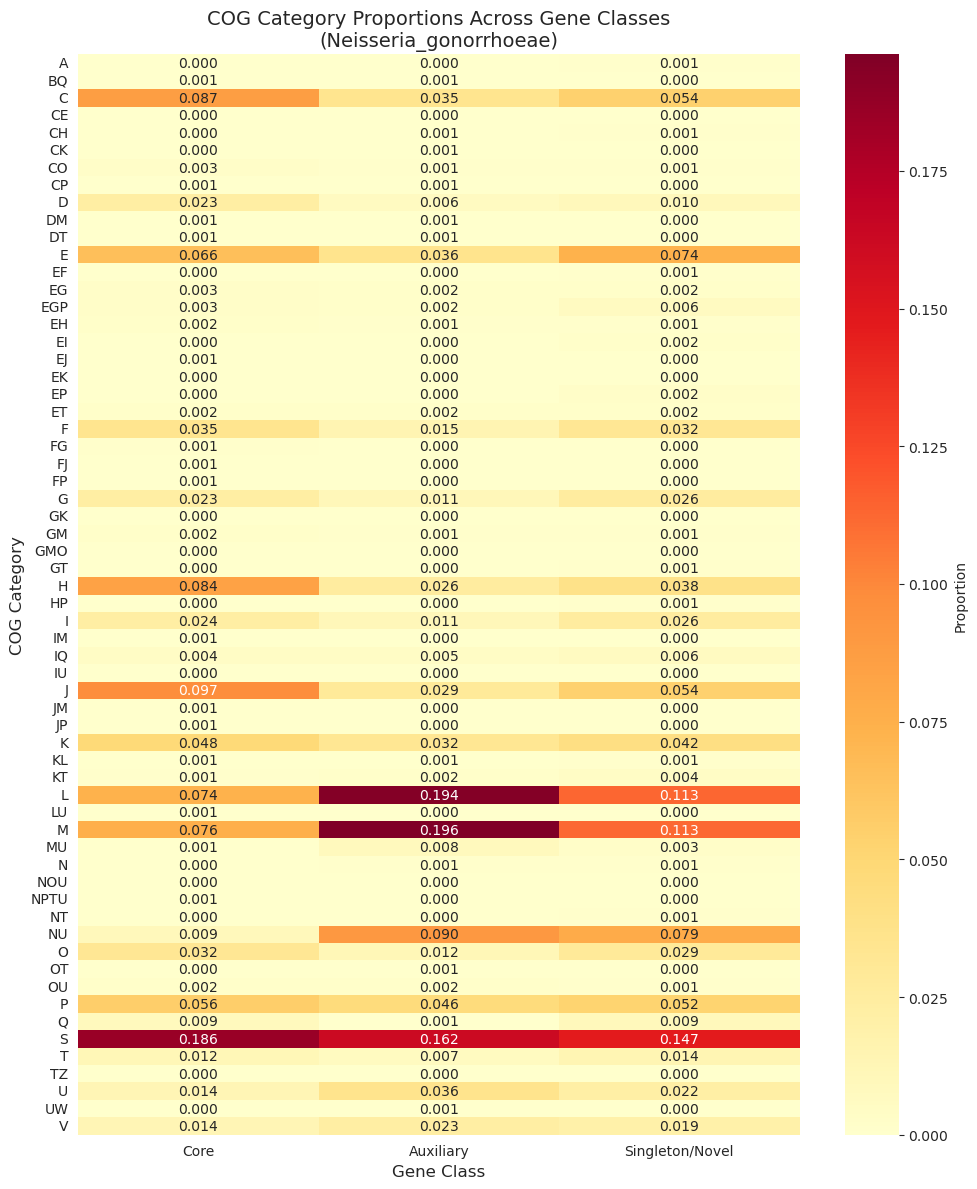

Heatmap saved to ../data/cog_heatmap.png


In [12]:
# Create pivot table for heatmap
pivot_df = combined_df.pivot_table(
    index='COG_category', 
    columns='gene_class', 
    values='proportion',
    fill_value=0
)

# Reorder columns
col_order = ['Core', 'Auxiliary', 'Singleton/Novel']
pivot_df = pivot_df[[col for col in col_order if col in pivot_df.columns]]

# Create heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Proportion'})
plt.title(f'COG Category Proportions Across Gene Classes\n({SPECIES_ID.split("--")[0].replace("s__", "")})', fontsize=14)
plt.xlabel('Gene Class', fontsize=12)
plt.ylabel('COG Category', fontsize=12)
plt.tight_layout()
plt.savefig('../data/cog_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Heatmap saved to ../data/cog_heatmap.png")

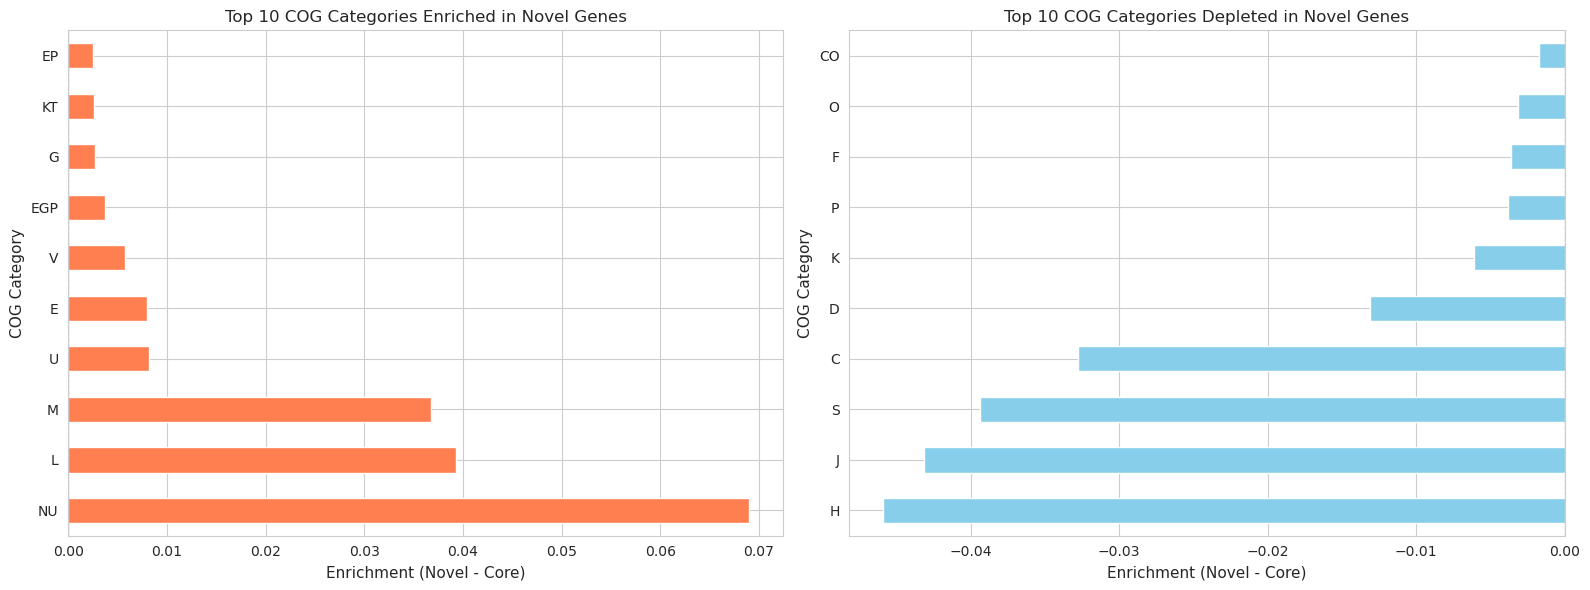

Enrichment plot saved to ../data/cog_enrichment.png


In [13]:
# Bar plot showing relative enrichment
core_props = pivot_df['Core']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top enriched in Novel vs Core
enrichment = (pivot_df['Singleton/Novel'] - core_props).sort_values(ascending=False)
top_enriched = enrichment.head(10)

ax = axes[0]
top_enriched.plot(kind='barh', ax=ax, color='coral')
ax.set_xlabel('Enrichment (Novel - Core)', fontsize=11)
ax.set_ylabel('COG Category', fontsize=11)
ax.set_title('Top 10 COG Categories Enriched in Novel Genes', fontsize=12)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Plot 2: Top depleted in Novel vs Core
bottom_enriched = enrichment.tail(10).sort_values()

ax = axes[1]
bottom_enriched.plot(kind='barh', ax=ax, color='skyblue')
ax.set_xlabel('Enrichment (Novel - Core)', fontsize=11)
ax.set_ylabel('COG Category', fontsize=11)
ax.set_title('Top 10 COG Categories Depleted in Novel Genes', fontsize=12)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig('../data/cog_enrichment.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enrichment plot saved to ../data/cog_enrichment.png")

## Step 7: Statistical summary

In [14]:
# Summary statistics
print("\n=== SUMMARY ===")
print(f"\nSpecies analyzed: {SPECIES_ID}")
print("\nTotal genes analyzed by class:")
print(combined_df.groupby('gene_class')['gene_count'].sum())

print("\nNumber of COG categories found in each class:")
print(combined_df.groupby('gene_class')['COG_category'].nunique())

print("\n=== KEY FINDINGS ===")
enrichment = (pivot_df['Singleton/Novel'] - pivot_df['Core'])

print("\nMost enriched in Novel genes (vs Core):")
for cog in enrichment.nlargest(5).index:
    enrich_val = enrichment[cog]
    desc = COG_DESCRIPTIONS.get(cog, 'Unknown')
    print(f"  {cog} ({desc}): +{enrich_val:.3f}")

print("\nMost depleted in Novel genes (vs Core):")
for cog in enrichment.nsmallest(5).index:
    enrich_val = enrichment[cog]
    desc = COG_DESCRIPTIONS.get(cog, 'Unknown')
    print(f"  {cog} ({desc}): {enrich_val:.3f}")


=== SUMMARY ===

Species analyzed: s__Neisseria_gonorrhoeae--RS_GCF_003315235.1

Total genes analyzed by class:
gene_class
Auxiliary          1769
Core               1478
Singleton/Novel    2025
Name: gene_count, dtype: int64

Number of COG categories found in each class:
gene_class
Auxiliary          39
Core               43
Singleton/Novel    52
Name: COG_category, dtype: int64

=== KEY FINDINGS ===

Most enriched in Novel genes (vs Core):
  NU (Unknown): +0.069
  L (Replication, recombination, repair): +0.039
  M (Cell wall/membrane biogenesis): +0.037
  U (Intracellular trafficking): +0.008
  E (Amino acid transport and metabolism): +0.008

Most depleted in Novel genes (vs Core):
  H (Coenzyme transport and metabolism): -0.046
  J (Translation, ribosomal structure): -0.043
  S (Function unknown): -0.039
  C (Energy production and conversion): -0.033
  D (Cell cycle control, division): -0.013
